#**Pipe 2:**

**Check for damage car or not**

**data1a - whole cars vs. all damaged cars**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Imports

Here we will be making use of the Keras library for creating our model and training it. We also use Matplotlib and Seaborn for visualizing our dataset to gain a better understanding of the images we are going to be handling. Another important library to handle image data is Opencv.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator,array_to_img,load_img,img_to_array
from keras.applications.imagenet_utils import preprocess_input

import tensorflow as tf

from sklearn.metrics import classification_report,confusion_matrix

from IPython.display import Image

import cv2
import os

import numpy as np

##**Loading the data** 

Next, let’s define the path to our data. Let’s define a function called get_data() that makes it easier for us to create our train and validation dataset. We define the two labels ‘00-Damaged’ and ‘01-whole’ that we will use. We use the Opencv imread function to read the images in the RGB format and resize the images to our desired width and height in this case both being 256.

In [ ]:
# dimensions of our images
img_width, img_height = 256, 256

labels = ['00-damage', '01-whole']

def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_width, img_height)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
train = get_data('/content/drive/MyDrive/NNDL/Datasets/case_study/data1a/training')
val = get_data('/content/drive/MyDrive/NNDL/Datasets/case_study/data1a/validation')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


##**Visualize the data**

Let’s visualize our data and see what exactly we are working with. We use seaborn to plot the number of images in both the classes and you can see what the output looks like.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


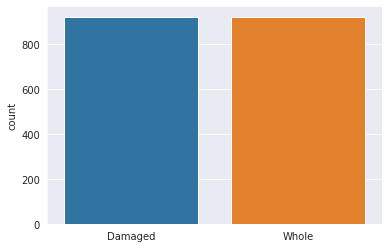

In [ ]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Damaged")
    else:
        l.append("Whole")
sns.set_style('darkgrid')
sns.countplot(l)

##Data Preprocessing and Data Augmentation

Next, we perform some Data Preprocessing and Data Augmentation before we can proceed with building the model.

In [ ]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_width, img_height, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_width, img_height, 1)
y_val = np.array(y_val)

Data augmentation on the train data:-

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

## **Baseline Model**

##**Define the Model** 

Let’s define a simple CNN model with 3 Convolutional layers followed by max-pooling layers. A dropout layer is added after the 3rd maxpool operation to avoid overfitting.

In [ ]:
base_model = Sequential()
base_model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(256,256,3)))
base_model.add(MaxPool2D())

base_model.add(Conv2D(32, 3, padding="same", activation="relu"))
base_model.add(MaxPool2D())

base_model.add(Conv2D(64, 3, padding="same", activation="relu"))
base_model.add(MaxPool2D())
base_model.add(Dropout(0.4))

base_model.add(Flatten())
base_model.add(Dense(128,activation="relu"))
base_model.add(Dense(2, activation="softmax"))

base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0

Let’s compile the model now using Adam as our optimizer and SparseCategoricalCrossentropy as the loss function.

In [ ]:
base_model.compile(optimizer = 'adam' , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])

In [ ]:
history = base_model.fit(x_train,y_train,epochs = 30 , validation_data = (x_val, y_val))

Epoch 1/30
58/58 [==============================] - 19s 136ms/step - loss: 0.6562 - accuracy: 0.6283 - val_loss: 0.6162 - val_accuracy: 0.6435
Epoch 2/30
58/58 [==============================] - 6s 111ms/step - loss: 0.4844 - accuracy: 0.7739 - val_loss: 0.4746 - val_accuracy: 0.7522
Epoch 3/30
58/58 [==============================] - 6s 111ms/step - loss: 0.3812 - accuracy: 0.8288 - val_loss: 0.4384 - val_accuracy: 0.7891
Epoch 4/30
58/58 [==============================] - 6s 111ms/step - loss: 0.3563 - accuracy: 0.8489 - val_loss: 0.4122 - val_accuracy: 0.8174
Epoch 5/30
58/58 [==============================] - 6s 111ms/step - loss: 0.2518 - accuracy: 0.9000 - val_loss: 0.3903 - val_accuracy: 0.8130
Epoch 6/30
58/58 [==============================] - 6s 112ms/step - loss: 0.1919 - accuracy: 0.9234 - val_loss: 0.4735 - val_accuracy: 0.8087
Epoch 7/30
58/58 [==============================] - 7s 112ms/step - loss: 0.1323 - accuracy: 0.9484 - val_loss: 0.4796 - val_accuracy: 0.7891
Epoch

##**Evaluating the result**

We will plot our training and validation accuracy along with training and validation loss.

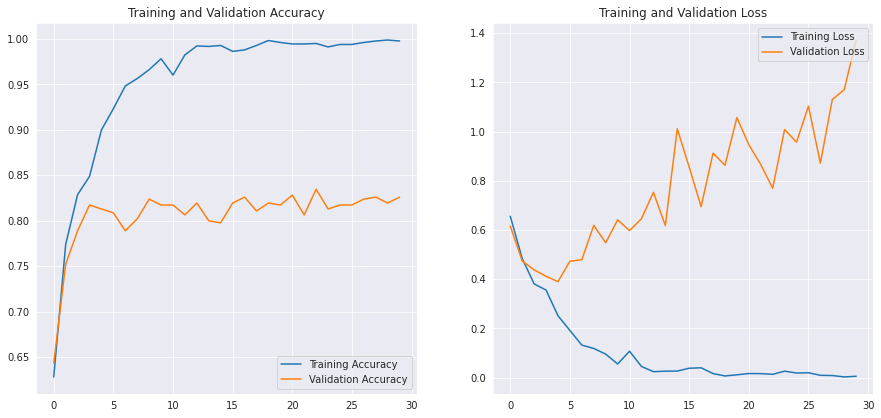

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
print("Evaluate on test data")
results_bm = base_model.evaluate(x_val, y_val)
print("test loss, test acc:", results_bm)

Evaluate on test data
15/15 [==============================] - 1s 49ms/step - loss: 1.3727 - accuracy: 0.8261
test loss, test acc: [1.372714638710022, 0.8260869383811951]


In [ ]:
y_predicted = base_model.predict(x_val)
y_predicted=np.argmax(y_predicted, axis=1)

In [ ]:
print(y_predicted)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1
 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1
 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1
 0 0 0 0 1 1 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 0
 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0]


In [ ]:
print(classification_report(y_val, y_predicted, target_names = ['Damaged (Class 0)','Whole (Class 1)']))

                   precision    recall  f1-score   support

Damaged (Class 0)       0.78      0.90      0.84       230
  Whole (Class 1)       0.88      0.75      0.81       230

         accuracy                           0.83       460
        macro avg       0.83      0.83      0.83       460
     weighted avg       0.83      0.83      0.83       460



In [ ]:
cm = confusion_matrix(y_predicted, y_val)
print(cm)

[[207  57]
 [ 23 173]]


In [ ]:
heatmap_labels = ['Damaged', 'Whole']

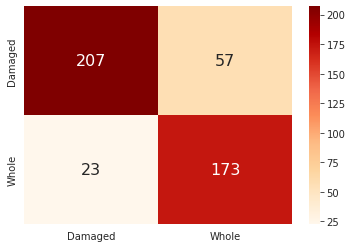

In [ ]:
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, 
            fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

As we can see our simple CNN model was able to achieve an accuracy of 60%. With some hyperparameter tuning, we might be able to achieve an increase in accuracy.

This is a baseline model with just 3 convolution layers. If we use transfer learning using models like VGG16 we can see an increase in the accuracy. 

In [ ]:
def prepare_image(img_path):
    img = load_img(img_path, target_size=(256, 256))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [ ]:
def validate_1(img_dir_path,image_path):
    print(image_path)
    image_path= img_dir_path+image_path
    img = prepare_image(image_path)
    out = base_model.predict(img)
    print(out)

    res = ['Damaged Car','Not Damaged']
    display(Image(image_path))

    return res[np.argmax(out)]

0230.JPEG
[[0. 1.]]


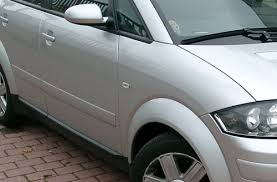

Not Damaged



In [ ]:
img_path = '/content/drive/MyDrive/NNDL/Datasets/case_study/data1a/validation/01-whole/'
print(validate_1(img_path,'0230.JPEG'))
print()

0039.JPEG
[[0. 1.]]


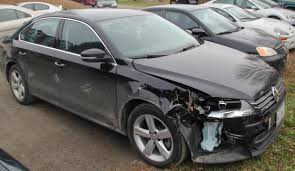

Not Damaged



In [ ]:
img_path = '/content/drive/MyDrive/NNDL/Datasets/case_study/data1a/validation/00-damage/'
print(validate_1(img_path,'0039.JPEG'))
print()


[[0. 1.]]


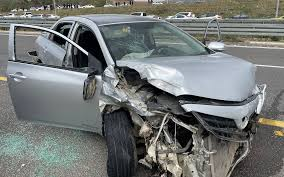

Not Damaged



In [ ]:
img_path = '/content/8.jpg'
print(validate_1(img_path,''))
print()

## **Using Transfer Learning**

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
tl_model = Sequential()
tl_model.add(VGG16(weights="imagenet", include_top=False, input_shape=(img_width, img_height, 3)))
tl_model.add(Flatten())
tl_model.add(Dense(128, activation="relu"))
tl_model.add(Dense(128, activation="relu"))
tl_model.add(Dense(64, activation="relu"))
tl_model.add(Dense(2, activation="sigmoid"))

tl_model.layers[-6].trainable = False

tl_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               4194432   
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 2)                 130       
                                                       

In [ ]:
tl_model.compile(optimizer = 'adam' , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])

In [ ]:
history = tl_model.fit(x_train,y_train,epochs = 30 , validation_data = (x_val, y_val))

Epoch 1/30
58/58 [==============================] - 41s 607ms/step - loss: 0.5141 - accuracy: 0.8293 - val_loss: 0.2099 - val_accuracy: 0.9217
Epoch 2/30
58/58 [==============================] - 26s 457ms/step - loss: 0.2098 - accuracy: 0.9141 - val_loss: 0.1841 - val_accuracy: 0.9283
Epoch 3/30
58/58 [==============================] - 26s 456ms/step - loss: 0.1105 - accuracy: 0.9609 - val_loss: 0.2271 - val_accuracy: 0.9239
Epoch 4/30
58/58 [==============================] - 26s 456ms/step - loss: 0.0285 - accuracy: 0.9929 - val_loss: 0.2652 - val_accuracy: 0.9130
Epoch 5/30
58/58 [==============================] - 26s 456ms/step - loss: 0.0165 - accuracy: 0.9962 - val_loss: 0.2426 - val_accuracy: 0.9217
Epoch 6/30
58/58 [==============================] - 26s 457ms/step - loss: 0.0065 - accuracy: 0.9995 - val_loss: 0.2596 - val_accuracy: 0.9217
Epoch 7/30
58/58 [==============================] - 26s 457ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.2802 - val_accuracy: 0.9283

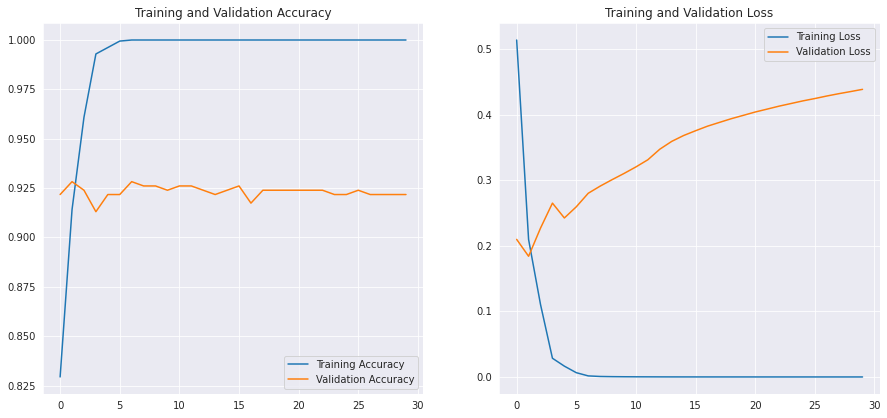

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
print("Evaluate on test data")
results_tl = tl_model.evaluate(x_val, y_val)
print("test loss, test acc:", results_tl)

Evaluate on test data
15/15 [==============================] - 5s 355ms/step - loss: 0.4388 - accuracy: 0.9217
test loss, test acc: [0.4387783408164978, 0.9217391014099121]


In [ ]:
y_predicted = tl_model.predict(x_val)
y_predicted=np.argmax(y_predicted, axis=1)

In [ ]:
print(y_predicted)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 0 1 1 0 0 0 1
 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
print(classification_report(y_val, y_predicted, target_names = ['Damaged (Class 0)','Whole (Class 1)']))

                   precision    recall  f1-score   support

Damaged (Class 0)       0.92      0.93      0.92       230
  Whole (Class 1)       0.93      0.92      0.92       230

         accuracy                           0.92       460
        macro avg       0.92      0.92      0.92       460
     weighted avg       0.92      0.92      0.92       460



In [ ]:
def prepare_image(img_path):
    img = load_img(img_path, target_size=(256, 256))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [ ]:
def validate(img_dir_path,image_path):
    print(image_path)
    image_path= img_dir_path+image_path
    img = prepare_image(image_path)
    out = tl_model.predict(img)
    print(out)

    res = ['Damaged Car','Not Damaged']
    display(Image(image_path))

    return res[np.argmax(out)]

0016.jpg
[[6.833032e-37 1.000000e+00]]


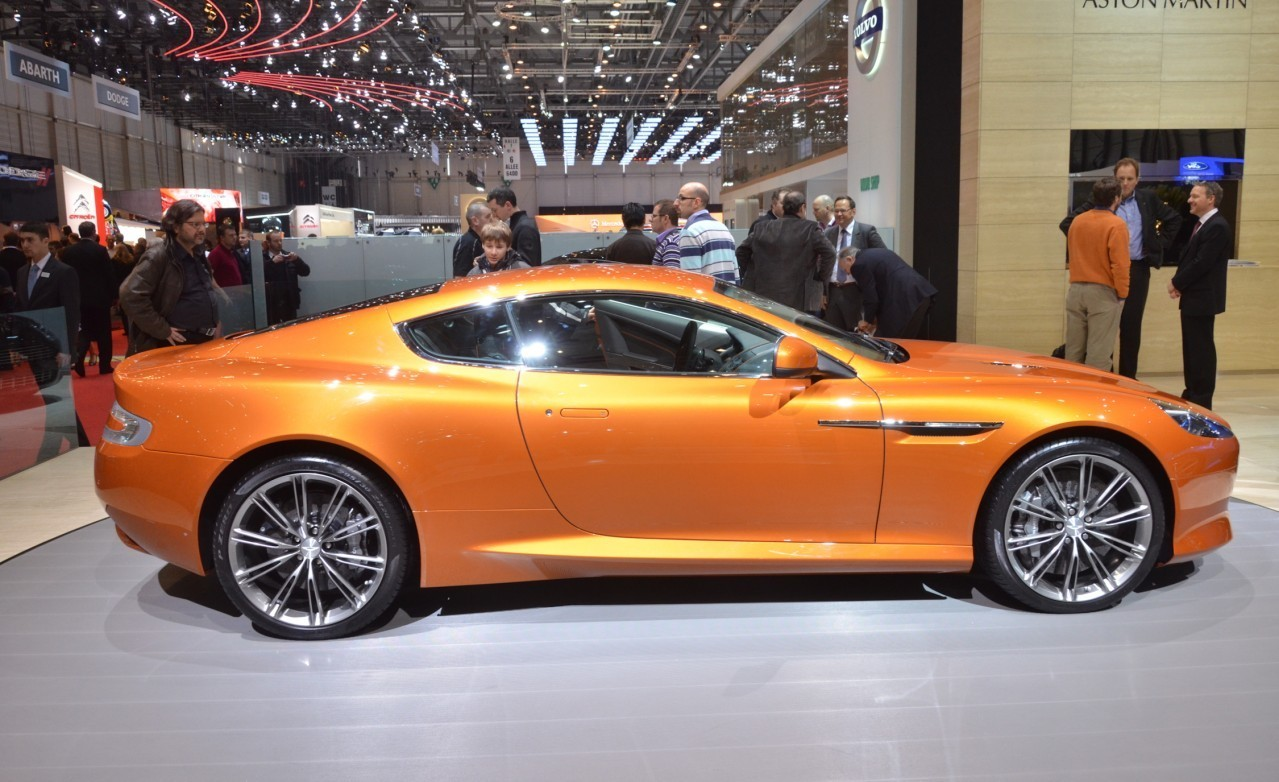

Not Damaged



In [ ]:
img_path = '/content/drive/MyDrive/NNDL/Datasets/case_study/data1a/validation/01-whole/'
print(validate(img_path,'0016.jpg'))
print()

0210.JPEG
[[1.0000000e+00 6.8312824e-38]]


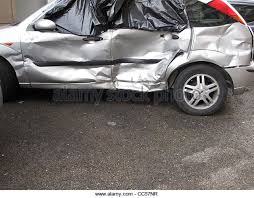

Damaged Car



In [ ]:
img_path = '/content/drive/MyDrive/NNDL/Datasets/case_study/data1a/validation/00-damage/'
print(validate(img_path,'0210.JPEG'))
print()


[[1.000000e+00 5.557811e-26]]


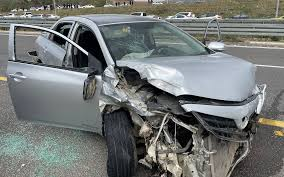

Damaged Car



In [ ]:
img_path = '/content/8.jpg'
print(validate(img_path,''))
print()

Comparison Between Base Model and Transfer Learning:

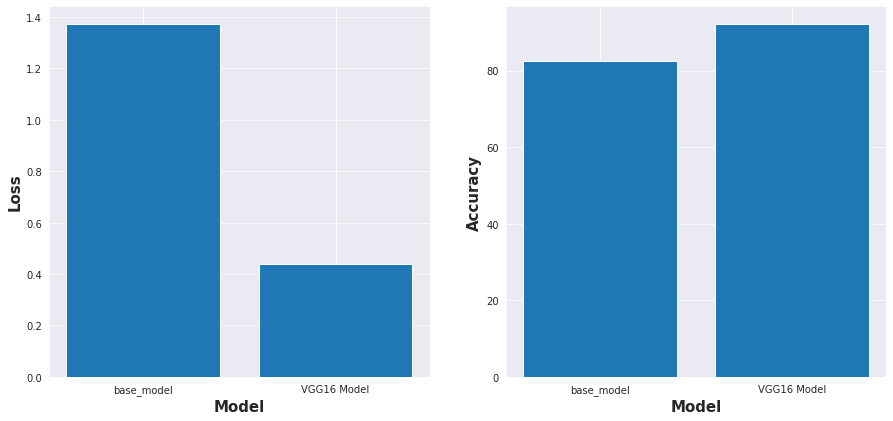

In [ ]:
loss_bm,accuracy_bm = results_bm
loss_tl,accuracy_tl = results_tl

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.bar(['base_model','VGG16 Model'], [loss_bm,loss_tl])
plt.xlabel('Model', fontweight ='bold', fontsize = 15)
plt.ylabel('Loss', fontweight ='bold', fontsize = 15)

plt.subplot(2, 2, 2)
plt.bar(['base_model','VGG16 Model'], [accuracy_bm*100,accuracy_tl*100])
plt.xlabel('Model', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracy', fontweight ='bold', fontsize = 15)

plt.show()